In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from distfit import distfit
%matplotlib inline

import metrics

In [3]:
PD_COUNT = 100
PD_CENTER = 750
PD_SIGMA = 150

NUMBER_OF_RESPONSES=1000

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 25060.5] [loc=0.997 scale=0.002]
[distfit] >INFO> [norm] [0.00 sec] [RSS: 25060.5] [loc=0.997 scale=0.002]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.996614, scale:0.002462)
[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: nan] [loc=1.000 scale=0.000]
[distfit] >INFO> [norm] [0.00 sec] [RSS: nan] [loc=1.000 scale=0.000]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:1.000000, scale:0.000000)
[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: nan] [loc=0.910 scale=0

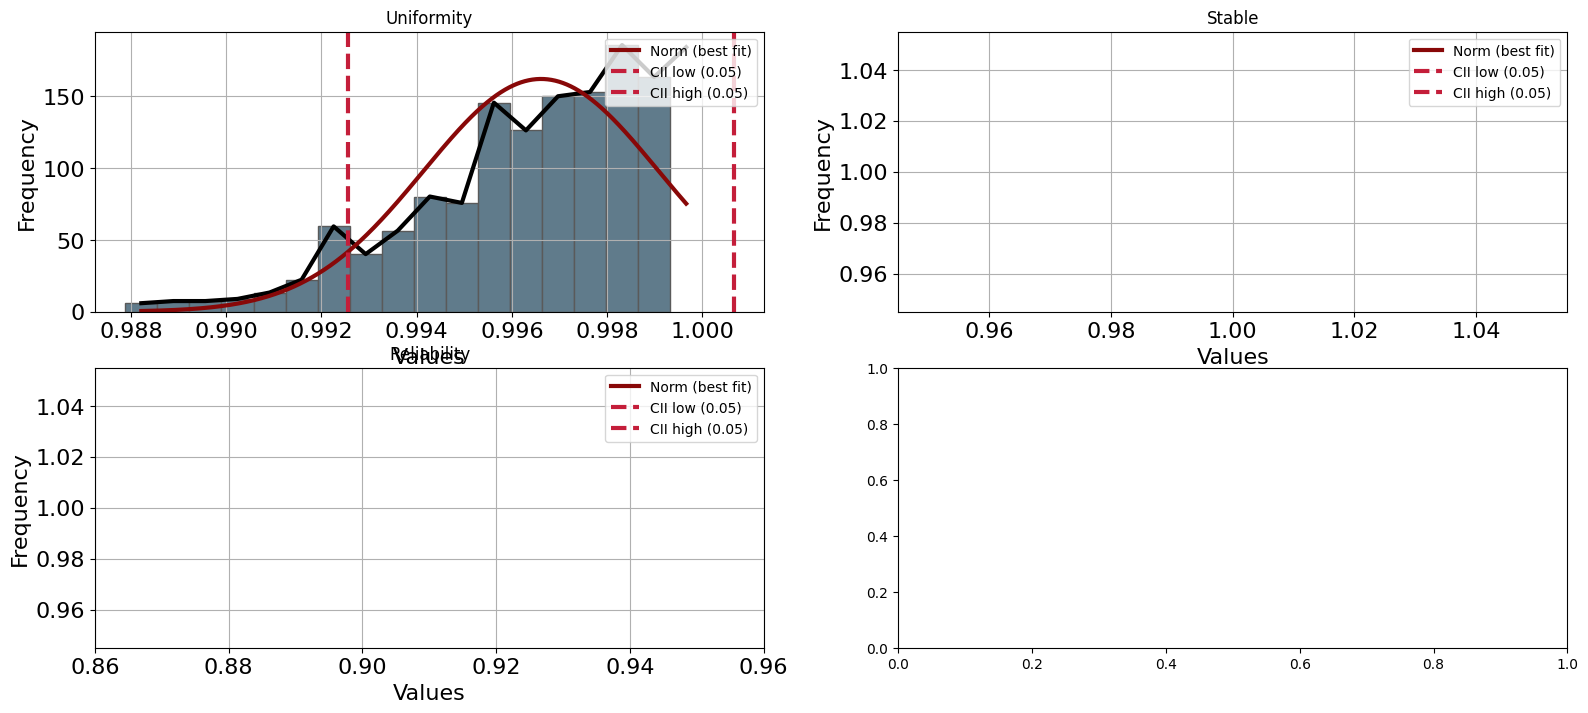

In [ ]:
pds = []
for i in range(4):
    pds.append(np.random.normal(PD_CENTER, PD_SIGMA, PD_COUNT))

res = metrics.calc_metrics(pds, NUMBER_OF_RESPONSES)
metrics.plot_metrics(res)

In [ ]:




def analyze_uniqueness(fpga_num: int) -> float:
    total = []
    for _ in range(100):
        fpga_resp = []
        for cur_iter in range(fpga_num):
            pd = generate_propagation_delays(PD_COUNT)
            pairs = select_pairwise(pd)
            bit_vector = calc_bit_vector_new(pairs)
            fpga_resp.append(bit_vector)

        total = 0
        for i in range(0, fpga_num - 1):
            for j in range(i + 1, fpga_num):
                total += distance.hamming(fpga_resp[i], fpga_resp[j])

        result = 2 / (fpga_num * (fpga_num - 1)) * total
        total.append(result)

    plot_results(total)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.0 sec] [RSS: 25093.9] [loc=0.996 scale=0.003]
[distfit] >INFO> [norm] [0.0 sec] [RSS: 25093.9] [loc=0.996 scale=0.003]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.996333, scale:0.002856)


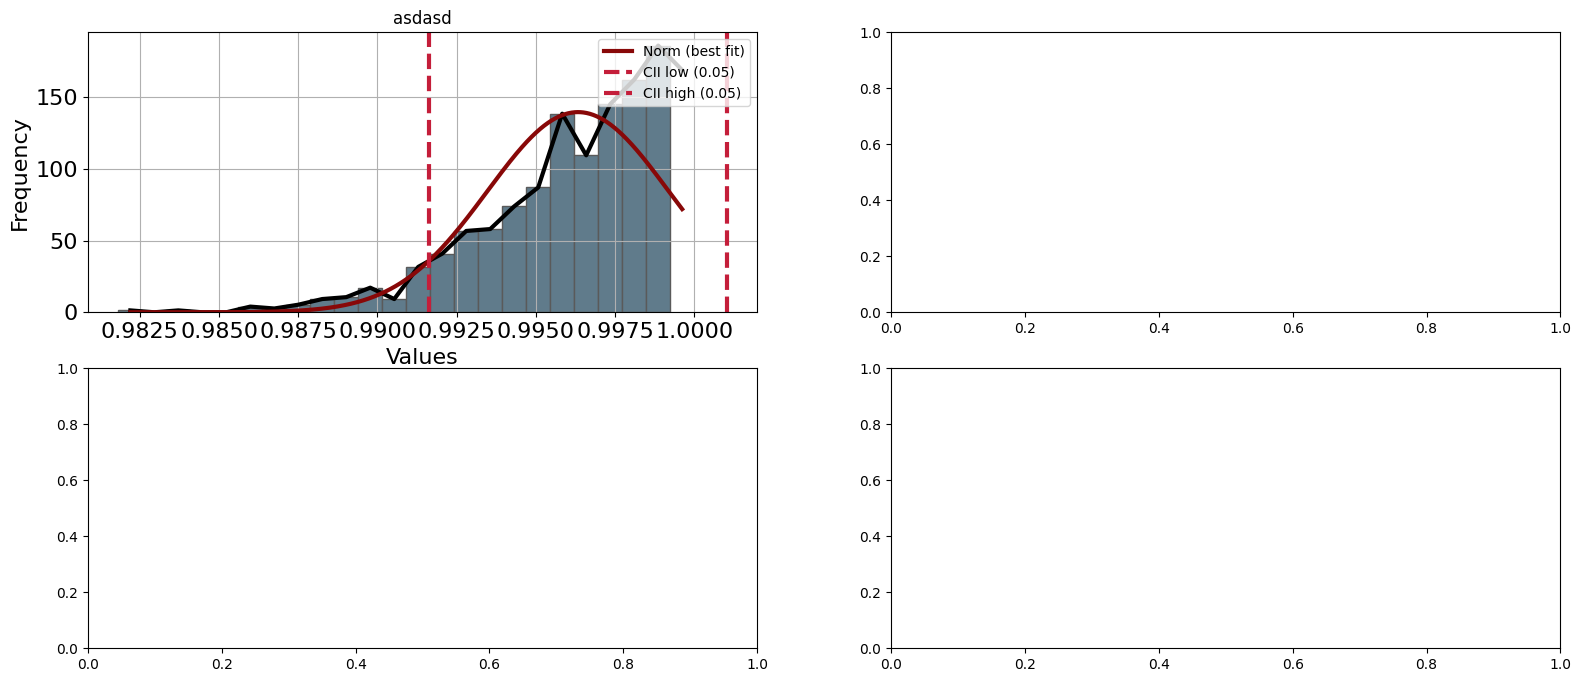

In [ ]:
analyze_unif()

In [7]:
# analyze_reliability(50)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 1.01555e+06] [loc=0.500 scale=0.000]
[distfit] >INFO> [norm] [0.00 sec] [RSS: 1.01555e+06] [loc=0.500 scale=0.000]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.500023, scale:0.000152)


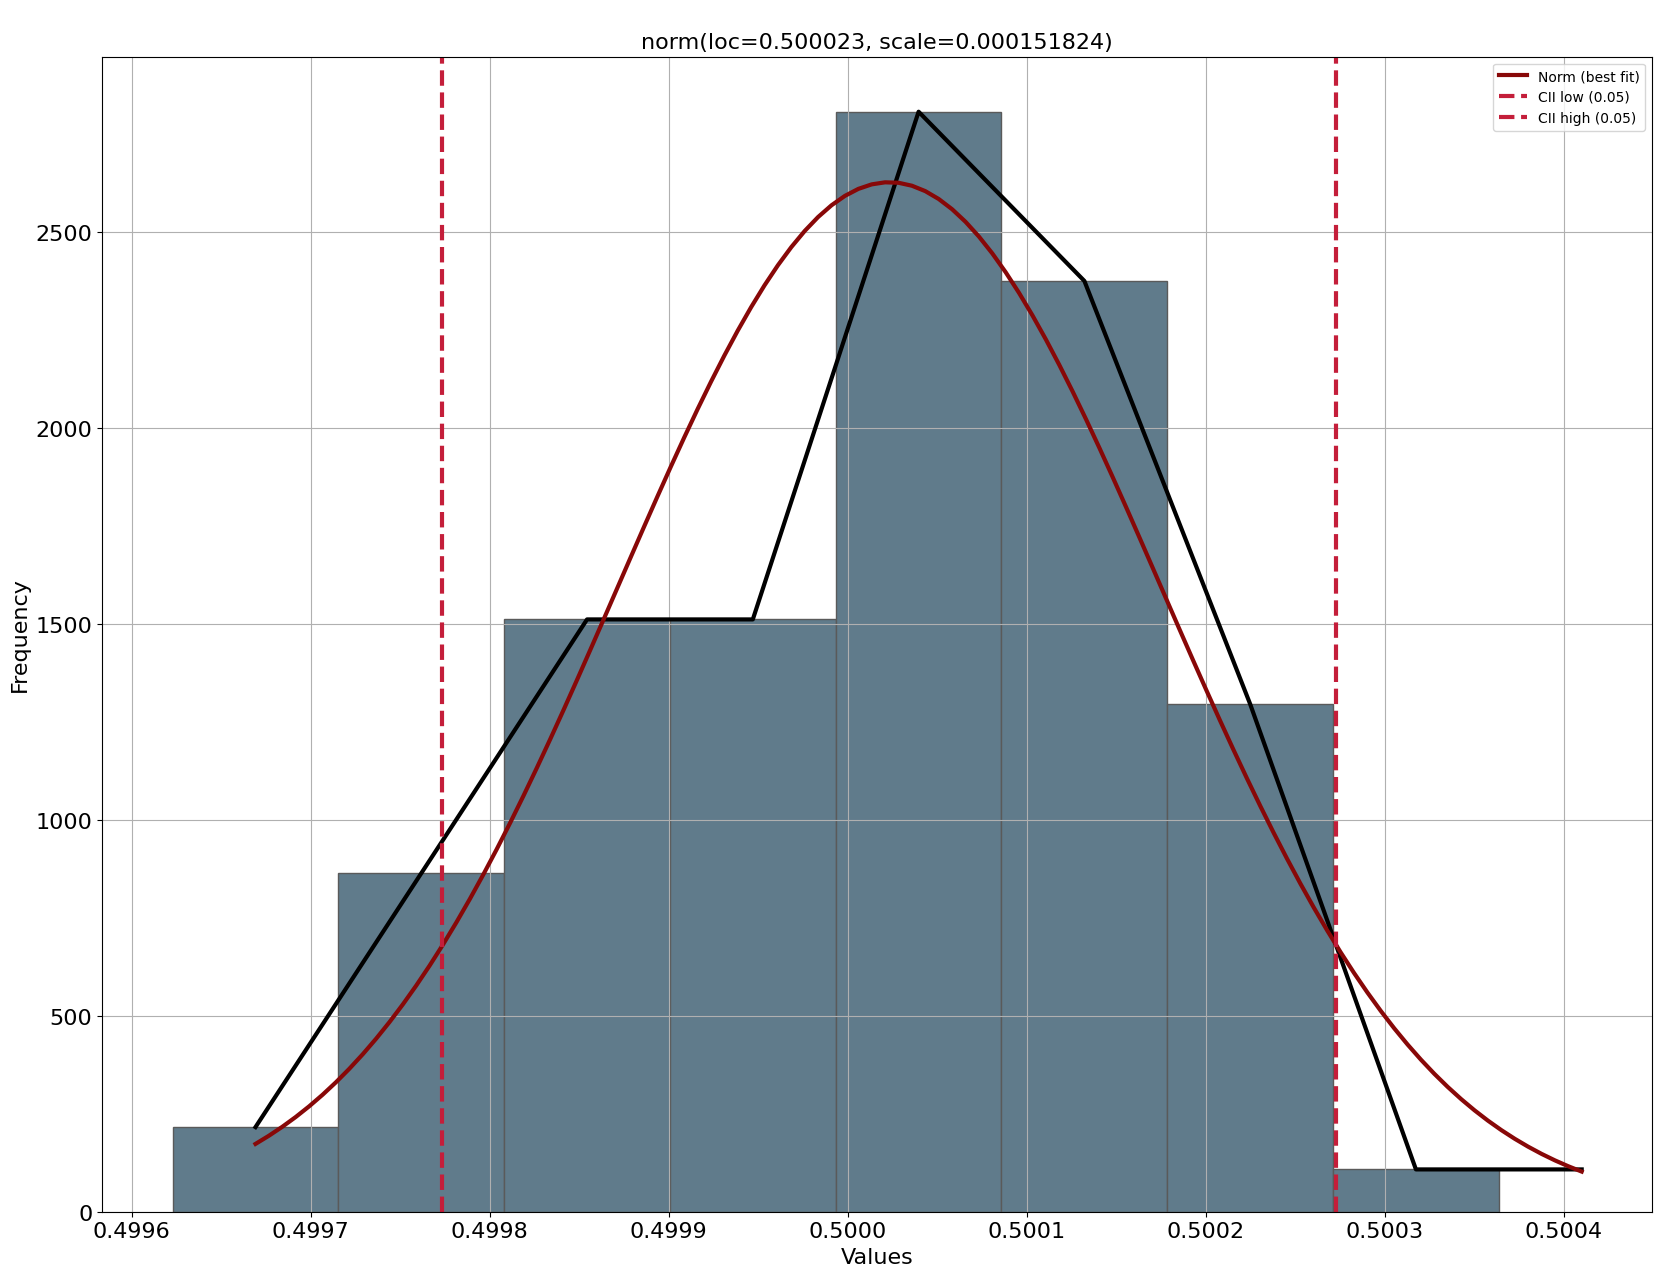

In [8]:
analyze_uniqueness(50)

In [33]:
analyze_stable()

1

In [12]:
def read_pd_from_file(filename: str) -> np.array:
    with open(filename, 'r') as file:
        lines = file.readlines()
        result = np.zeros(len(lines), dtype=np.int32)

        for i, l in enumerate(lines):
            result[i] = int(l)
        
        return result 

In [13]:
pd = read_pd_from_file('DataSet_01/F0/CRO_REAL_FIXED_F0_C0.txt')
print(pd)

[32785 32823 32702 ... 32749 32731 32582]


In [ ]:
def analyze_metrics():
    py